In [7]:
# filter warnings messages from the notebook
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os
from copy import deepcopy

from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval

import pymatgen as pym

# Set pandas view options
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
def magpie_featurize_data(df,comp_col='Composition_Formula',
                             keep_comp_col = False,
                             keep_cols=[],
                             elem_prop=None):
    
    print("Shape of df to featurize: ", df.shape)
    origcols = set(df.columns)
        
    df = StrToComposition(target_col_id='composition_obj').\
                      featurize_dataframe(df, comp_col)

    feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), 
                                              cf.ElementProperty.from_preset("magpie"),
                                              cf.ValenceOrbital(props=['avg']), 
                                              cf.IonProperty(fast=True)])

    feature_labels = feature_calculators.feature_labels()

    df = feature_calculators.featurize_dataframe(df,col_id='composition_obj')

    #df.columns = [col.replace('_','\_') for col in df.columns]
    df.columns = [col.replace('MagpieData','') for col in df.columns]
    df.columns = [col.replace('average','mu') for col in df.columns]
    df.columns = [col.replace('maximum','max') for col in df.columns]
    df.columns = [col.replace('minimum','min') for col in df.columns]
    
    if keep_comp_col:
        origcols.remove(comp_col)
    
    for elem in keep_cols:
        try:
            origcols.remove(elem)
        except:
            pass
    
    features = df.drop(list(origcols)+['composition_obj'],
                       axis=1,inplace=False)
        
    if elem_prop is not None:
        elemH_formE = [cweighted_elementalH_formE(c,elem_prop)\
                   for c in df['composition_obj']]
        elemH_formE_df = pd.DataFrame(elemH_formE,columns=['E_HM min',
                                                           'E_HM max',
                                                           'E_HM mu',
                                                           'E_HM dev'])
        aug_features = pd.concat((features,elemH_formE_df),axis=1,sort=False)
        #print(aug_features.columns)
    else:
        aug_features = deepcopy(features)
        
    print("Shape of returned features: ", aug_features.shape)
    return aug_features

In [9]:
api_key = None   # Set your MP API key here. If set as an environment variable 'MAPI_KEY', set it to 'None'
mpr = MPDataRetrieval(os.environ['MY_MP_API'])     # Create an adapter to the MP Database.

# criteria is to get all entries with elasticity (K_VRH is bulk modulus) data
criteria = {'elasticity.K_VRH': {'$ne': None}}

# properties are the materials attributes we want
# See https://github.com/materialsproject/mapidoc for available properties you can specify
properties = ['pretty_formula', 'spacegroup.symbol', 'elasticity.K_VRH', 'formation_energy_per_atom', 'band_gap',
              'e_above_hull', 'density', 'volume', 'nsites']

# get the data!
df_mp_orig = mpr.get_dataframe(criteria=criteria, properties=properties)
print('Number of bulk moduli extracted = {}'.format(len(df_mp_orig)))

100%|██████████| 13172/13172 [00:11<00:00, 1194.23it/s]

Number of bulk moduli extracted = 13172


In [10]:
df_mp = deepcopy(df_mp_orig)
df_mp.head()
df_mp.describe()

,elasticity.K_VRH,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites
count,13172.000000,13172.000000,13172.000000,13172.000000,13172.000000,13172.000000,13172.000000
mean,101.763210,-0.847532,0.671362,0.096432,6.998474,141.718257,7.763134
std,72.728987,1.013787,1.405085,0.265915,3.385482,135.430947,7.881010
min,0.000000,-4.513010,0.000000,0.000000,0.023670,5.602384,1.000000
25%,45.000000,-1.187357,0.000000,0.000000,4.474429,66.173948,4.000000
50%,85.000000,-0.536274,0.000000,0.000000,6.613811,103.096526,5.000000
75%,146.000000,-0.241757,0.556400,0.049605,8.842227,168.836892,9.000000
max,591.000000,4.412093,17.652600,4.412093,22.165012,3390.625722,160.000000


In [11]:
df_mp = df_mp[df_mp['elasticity.K_VRH'] > 0]
df_mp = df_mp[df_mp['e_above_hull'] < 0.1]
df_mp = df_mp.dropna()
df_mp.describe()

,elasticity.K_VRH,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites
count,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000
mean,98.768355,-0.956631,0.746245,0.011081,7.029388,151.915624,8.283585
std,68.417595,0.958849,1.465732,0.021934,3.340361,142.600369,8.305099
min,1.000000,-4.513010,0.000000,0.000000,0.107073,6.926148,1.000000
25%,45.000000,-1.248292,0.000000,0.000000,4.501844,71.102107,4.000000
50%,84.000000,-0.591223,0.000000,0.000000,6.679733,110.953545,6.000000
75%,142.000000,-0.321101,0.859500,0.010991,8.880615,179.641389,10.000000
max,551.000000,0.099251,17.652600,0.099937,22.087251,3390.625722,160.000000


In [12]:
df_fea=pd.DataFrame()
df_fea["Composition_Formula"] = df_mp['pretty_formula'].map(lambda x: pym.core.Composition(x))

df_fea=magpie_featurize_data(df_fea)

Shape of df to featurize:  (10801, 1)


StrToComposition:   0%|          | 0/10801 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/10801 [00:00<?, ?it/s]

Shape of returned features:  (10801, 145)


In [13]:
df_fea.describe()

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,min Number,max Number,range Number,mean Number,avg_dev Number,mode Number,min MendeleevNumber,max MendeleevNumber,range MendeleevNumber,mean MendeleevNumber,avg_dev MendeleevNumber,mode MendeleevNumber,min AtomicWeight,max AtomicWeight,range AtomicWeight,mean AtomicWeight,avg_dev AtomicWeight,mode AtomicWeight,min MeltingT,max MeltingT,range MeltingT,mean MeltingT,avg_dev MeltingT,mode MeltingT,min Column,max Column,range Column,mean Column,avg_dev Column,mode Column,min Row,max Row,range Row,mean Row,avg_dev Row,mode Row,min CovalentRadius,max CovalentRadius,range CovalentRadius,mean CovalentRadius,avg_dev CovalentRadius,mode CovalentRadius,min Electronegativity,max Electronegativity,range Electronegativity,mean Electronegativity,avg_dev Electronegativity,mode Electronegativity,min NsValence,max NsValence,range NsValence,mean NsValence,avg_dev NsValence,mode NsValence,min NpValence,max NpValence,range NpValence,mean NpValence,avg_dev NpValence,mode NpValence,min NdValence,max NdValence,range NdValence,mean NdValence,avg_dev NdValence,mode NdValence,min NfValence,max NfValence,range NfValence,mean NfValence,avg_dev NfValence,mode NfValence,min NValence,max NValence,range NValence,mean NValence,avg_dev NValence,mode NValence,min NsUnfilled,max NsUnfilled,range NsUnfilled,mean NsUnfilled,avg_dev NsUnfilled,mode NsUnfilled,min NpUnfilled,max NpUnfilled,range NpUnfilled,mean NpUnfilled,avg_dev NpUnfilled,mode NpUnfilled,min NdUnfilled,max NdUnfilled,range NdUnfilled,mean NdUnfilled,avg_dev NdUnfilled,mode NdUnfilled,min NfUnfilled,max NfUnfilled,range NfUnfilled,mean NfUnfilled,avg_dev NfUnfilled,mode NfUnfilled,min NUnfilled,max NUnfilled,range NUnfilled,mean NUnfilled,avg_dev NUnfilled,mode NUnfilled,min GSvolume_pa,max GSvolume_pa,range GSvolume_pa,mean GSvolume_pa,avg_dev GSvolume_pa,mode GSvolume_pa,min GSbandgap,max GSbandgap,range GSbandgap,mean GSbandgap,avg_dev GSbandgap,mode GSbandgap,min GSmagmom,max GSmagmom,range GSmagmom,mean GSmagmom,avg_dev GSmagmom,mode GSmagmom,min SpaceGroupNumber,max SpaceGroupNumber,range SpaceGroupNumber,mean SpaceGroupNumber,avg_dev SpaceGroupNumber,mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,max ionic char,avg ionic char
count,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10800.000000,10800.000000,10800.000000,10800.000000,10800.000000,10800.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10801.000000,10801.000000,10801.00000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.00000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801

In [14]:
inds_nonNaN = np.array([i for i, (index, row) in enumerate(df_fea.iterrows()) if not row.isnull().any()])

In [16]:
y = np.array(df_mp['elasticity.K_VRH'].values,dtype='float32')[inds_nonNaN]
X = np.array(df_fea,dtype='float32')[inds_nonNaN]

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50, random_state=1)

rf.fit(X, y)
print('R2 = ' + str(round(rf.score(X, y), 3)))
print('RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=rf.predict(X))))

R2 = 0.966
RMSE = 12.664


In [23]:
from sklearn.model_selection import KFold, cross_val_score

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

# compute cross validation scores for random forest model
scores = cross_val_score(rf, X, y, scoring='neg_mean_squared_error',
                         cv=crossvalidation, n_jobs=1)
rmse_scores = [np.sqrt(abs(s)) for s in scores]

print('Cross-validation results:')
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

Cross-validation results:
Folds: 10, mean RMSE: 24.754


In [22]:
import sklearn
print(sorted(sklearn.metrics.SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v_measure_score']


In [26]:
import joblib
joblib.dump(rf,'models/bulk_modulus_rf.joblib')

['models/bulk_modulus_rf.joblib']

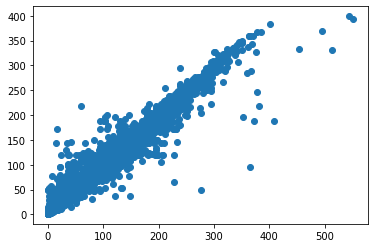

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1,ncols=1)
ax.scatter(y,rf.predict(X))
plt.show()

In [33]:
importances = rf.feature_importances_
X_cols = np.asarray(df_fea.columns)
indices = np.argsort(importances)[::-1]

print(X_cols[indices])
print(importances[indices])


[' mean MeltingT' ' mean GSvolume_pa' ' mean NdUnfilled'
 ' max GSvolume_pa' ' mean Electronegativity' ' max MendeleevNumber'
 ' avg_dev MeltingT' ' max MeltingT' ' mode MendeleevNumber'
 ' min MeltingT' ' mean MendeleevNumber' ' mean NUnfilled' ' min Column'
 ' mean CovalentRadius' 'avg p valence electrons' ' mode GSvolume_pa'
 ' mean NpValence' ' avg_dev GSvolume_pa' ' min Electronegativity'
 ' avg_dev CovalentRadius' ' min MendeleevNumber' ' mean Column'
 ' mode NUnfilled' ' range MeltingT' ' avg_dev NUnfilled'
 ' avg_dev MendeleevNumber' ' avg_dev GSbandgap'
 ' avg_dev Electronegativity' ' mean SpaceGroupNumber'
 ' max CovalentRadius' ' mean AtomicWeight' ' mode MeltingT'
 ' min NUnfilled' 'avg ionic char' ' avg_dev Column' ' mode Column'
 ' mode Electronegativity' ' avg_dev SpaceGroupNumber'
 ' avg_dev NpUnfilled' ' mean NValence' ' mean GSbandgap'
 ' avg_dev NdValence' ' avg_dev NValence' ' range Number'
 ' range GSvolume_pa' ' mean NpUnfilled' ' max Electronegativity'
 ' range M